In [1]:
using ForneyLab, Plots, Random, DelimitedFiles, DataFrames

In [2]:
Random.seed!(0);
#Generate data
T = 200

w1, w2 = 1, 10

y_data = [sqrt(1/w1)*randn()]
for t=2:50
    append!(y_data, y_data[end] + sqrt(1/w1)*randn())
end
for t=51:150
    append!(y_data, y_data[end] + sqrt(1/w2)*randn())
end
for t=151:T
    append!(y_data, y_data[end] + sqrt(1/w1)*randn())
end

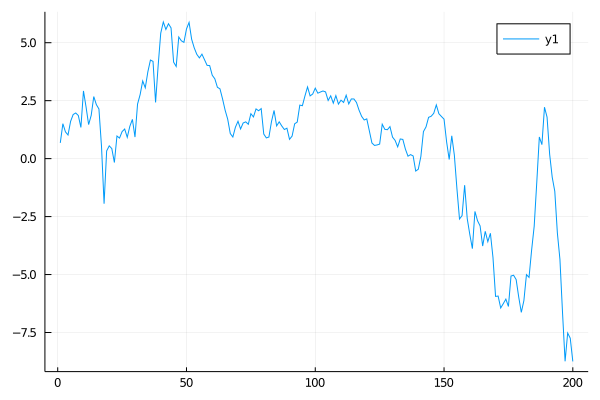

In [3]:
plot(y_data)

In [4]:
g = FactorGraph()

@RV M ~ Dirichlet([100 1; 1 100]) # Dirichlet prior that disfavors frequent state transitions

z = Vector{Variable}(undef, T-1) # one-hot coding
s = Vector{Variable}(undef, T-1)
x = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)

@RV z[1] ~ Categorical(ones(2)/2)
@RV x[1] ~ GaussianMeanVariance(0,1)
@RV y[1] ~ GaussianMeanVariance(x[1],0.1)
placeholder(y[1], :y, index=1)

f(z) = z[1]*w1 + z[2]*w2
@RV s[1] ~ Nonlinear{Sampling}(z[1],g=f)

for t = 2:T-1
    @RV x[t] ~ GaussianMeanPrecision(x[t-1],s[t-1])
    @RV y[t] ~ GaussianMeanVariance(x[t],0.1)
    @RV z[t] ~ Transition(z[t-1],M)
    @RV s[t] ~ Nonlinear{Sampling}(z[t],g=f)
    
    placeholder(y[t], :y, index=t)
end;

@RV x[T] ~ GaussianMeanPrecision(x[T-1],s[T-1])
@RV y[T] ~ GaussianMeanVariance(x[T],0.1)
placeholder(y[T], :y, index=T)
;

In [5]:
# Define posterior factorization
pfz = PosteriorFactorization()
q_M = PosteriorFactor(M, id=:M)

q_z = Vector{PosteriorFactor}(undef, T-1)
q_x = Vector{PosteriorFactor}(undef, T)
for t=1:T-1
    q_z[t] = PosteriorFactor(z[t],id=:Z_*t)
    q_x[t] = PosteriorFactor(x[t],id=:X_*t)
end
q_x[T] = PosteriorFactor(x[T],id=:X_*T)

# Compile algorithm
etime1 = @elapsed algo_mf = messagePassingAlgorithm(id=:MF, free_energy=true)

# Generate source code
etime2 = @elapsed code_mf = algorithmSourceCode(algo_mf, free_energy=true);

# Load algorithm
eval(Meta.parse(code_mf));

In [6]:
total_time = etime1 + etime2

49.346783932

In [7]:
# Initialize data
data = Dict(:y => y_data)
n_its = 50

# Initial posterior factors
marginals_mf = Dict{Symbol, ProbabilityDistribution}(:M => vague(Dirichlet, (2,2)))
for t = 1:T-1
    marginals_mf[:z_*t] = ProbabilityDistribution(Univariate, Categorical, p=[0.5,0.5])
    marginals_mf[:s_*t] = vague(SampleList)
    marginals_mf[:x_*t] = vague(GaussianMeanPrecision)
end
marginals_mf[:x_*T] = vague(GaussianMeanPrecision)

# Run algorithm
F_mf = Vector{Float64}(undef, n_its)
for i = 1:n_its
    etime = @elapsed stepMFM!(data, marginals_mf)
    total_time += etime
    for k = 1:T
        etime = @elapsed step!(:MFX_*k, data, marginals_mf)
        total_time += etime
    end
    for k = 1:T-1
        etime = @elapsed step!(:MFZ_*k, data, marginals_mf)
        total_time += etime
    end
    F_mf[i] = freeEnergyMF(data, marginals_mf)
end
;

In [8]:
total_time

137.34325235899976

In [9]:
marginals_mf[:M]

Dir(a=[[1.96e+02, 4.06][4.06, 1.96e+02]])


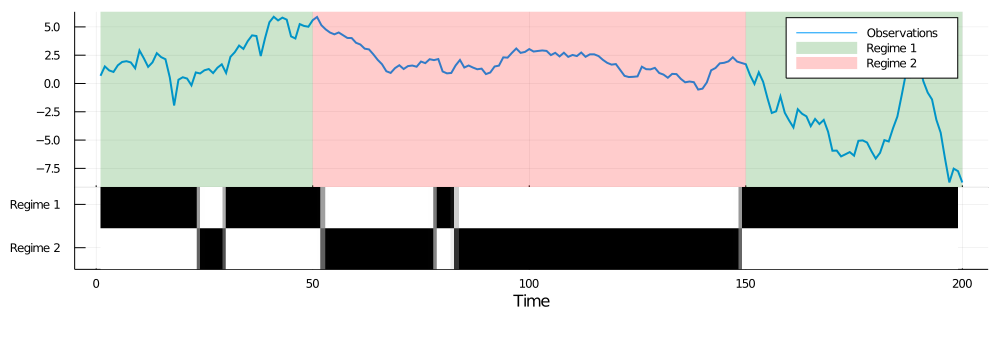

In [10]:
m_z = zeros(T-1)
for t=1:T-1
    m_z[t] = mean(marginals_mf[:z_*t])[1]
end

estimate = zeros(20,T-1)
for i=1:10
    estimate[i,:] = 1 .- m_z
    estimate[i+10,:] = m_z
end

gr()
l = @layout [a ; b]
mm=Plots.PlotMeasures.mm
p1 = plot(1:200, y_data, w=2, labels = "Observations", legend=(:best))
vspan!(p1,[1,50], color = :green, alpha = 0.2, labels = "Regime 1");
vspan!(p1,[50,150], color = :red, alpha = 0.2, labels = "Regime 2");
vspan!(p1,[150,T], color = :green, alpha = 0.2, labels = "");

p2 = plot(Gray.(estimate), link=:x, xlabel="Time", top_margin=-20.0mm)
yticks!([5:10:15;], ["Regime 1", "Regime 2"])

p = plot(p1, p2, layout = l, size = (1000, 350))

In [11]:
writedlm("FLestimates.txt", estimate)

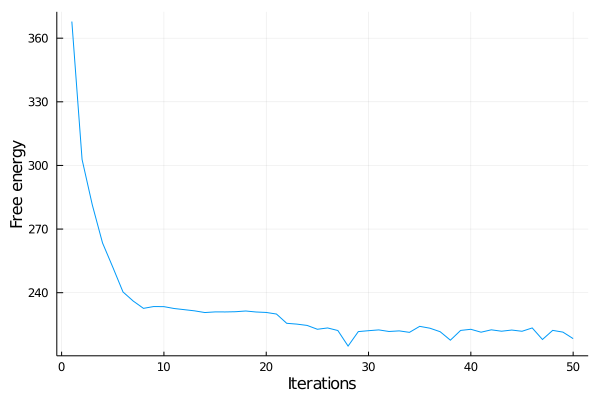

In [12]:
plot(F_mf, legend=false)
ylabel!("Free energy")
xlabel!("Iterations")